 Discriminator는 입력 이미지가 진짜인지 가짜인지를 판별해주는 분류기입니다.

그리고 Generator는 학습을 통해 가짜 이미지를 진짜 이미지처럼 생성하도록 학습됩니다. 그러나, 만약 Generator가 Discriminator를 속이도록 학습해본적이 없는 이미지들은 생성을 하게 되더라도 Discriminator가 가짜라고 판별을 할 것입니다. 즉, 이러한 개념을 Anomaly에 적용하여 주어진 데이터셋 내에서 정상 이미지만을 학습에 사용합니다. 따라서, 학습에서 사용되지 않은 비정상 이미지를 입력으로 넣었을 때, Generator는 해당 이미지를 제대로 생성해내지 못할 것이고, 그렇다면 Discriminator는 가짜라고 판별할 것이라는 아이디어입니다.

제가 생각하는 GAN과 AnoGAN의 차이점을 간략하게 정리해보았습니다.
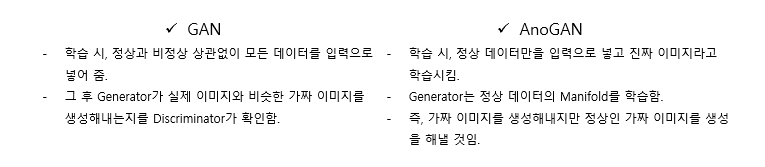
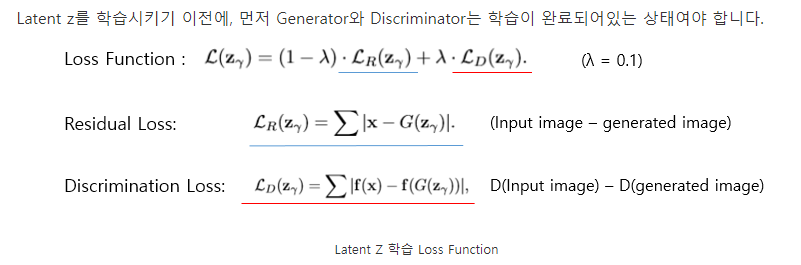
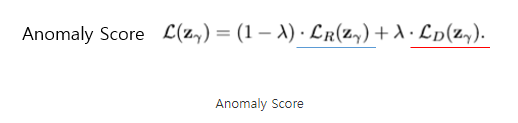

이렇게 학습된, z는 입력 이미지와 유사한 이미지라고 할 수 있습니다. 
따라서, 실제 테스트 이미지와 유사하도록 학습된 z를 넣는것입니다. 
그리고 실제로 Anomaly를 판별할 때, 위의 z를 학습할 때 사용했던 Loss Function을 Anomaly score로 사용하여 특정 임계치를 기준으로 정상인지 비정상인지를 판별합니다. 
보통 우변의 왼쪽항인 Residual Loss가 이미지에 anomalous한 영역을 판단하는 것으로 사용됩니다.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from network import *
from python_utils import *
import torchvision.utils as vutils
import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
import torch
import torchvision
import torchvision.transforms as transforms

In [24]:
class anomaly_dataset(Dataset):
    def __init__(self, inputs, labels, transform=None):
        self.inputs = inputs
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        inputs = np.transpose(self.inputs[idx], (2, 0, 1))
        labels = self.labels[idx]

        if self.transform:
            inputs = self.transform(inputs)

        return inputs, labels



epochs = 100
batch_size = 64
lr = 0.0002
ndf = 64
ngf = 64
latent_dim = 128
img_size = 64
channels = 3
n_critic = 5
split_rate = 0.8


# %%
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)


# Label 1을 Normal data, 나머지 0,2,3,4,5,6,7,8,9는 abnormal data
x_train_temp = torch.ByteTensor(trainset.data[torch.IntTensor(trainset.targets) == 1])
x_train_normal, x_valid_normal = x_train_temp.split((int(len(x_train_temp) * split_rate)), dim=0)

y_train_temp = torch.ByteTensor(trainset.targets)[torch.tensor(trainset.targets)==1]
y_train_normal, y_valid_normal = y_train_temp.split((int(len(y_train_temp) * split_rate)), dim=0)

train_cifar10 = anomaly_dataset(x_train_normal, y_train_normal, transform=transforms.Compose([
                                                                            transforms.ToPILImage(),
                                                                            transforms.Resize(img_size),
                                                                            transforms.ToTensor(),
                                                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                                                            ]))

train_loader = DataLoader(train_cifar10, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [31]:
print(train_loader)

In [32]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, num_gf=32, channels=3, bias=True):
        '''
        latent_dim: Latent vector dimension
        num_gf: Number of Generator Filters
        channels: Number of Generator output channels
        '''
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
                                   nn.ConvTranspose2d(latent_dim, num_gf*8, 4, 1, 0, bias=bias),
                                   nn.BatchNorm2d(num_gf*8),
                                   nn.ReLU(),
                                   
                                   nn.ConvTranspose2d(num_gf*8, num_gf*4, 4, 2, 1, bias=bias),
                                   nn.BatchNorm2d(num_gf*4),
                                   nn.ReLU(),
                                   
                                   nn.ConvTranspose2d(num_gf*4, num_gf*2, 4, 2, 1, bias=bias),
                                   nn.BatchNorm2d(num_gf*2),
                                   nn.ReLU(),
                                   
                                   nn.ConvTranspose2d(num_gf*2, num_gf, 4, 2, 1, bias=bias),
                                   nn.BatchNorm2d(num_gf),
                                   nn.ReLU(),

                                   nn.ConvTranspose2d(num_gf, channels, 4, 2, 1, bias=bias),
                                   nn.Tanh()
                                )

    def forward(self, z):
        z = self.layer(z)
        return z


class Discriminator(nn.Module):
    def __init__(self, num_df=32, channels=3, bias=True):
        super(Discriminator, self).__init__()
        self.feature_layer = nn.Sequential(
                                    nn.Conv2d(channels, num_df, 4, 2, 1, bias=bias),
                                    nn.BatchNorm2d(num_df),
                                    nn.LeakyReLU(0.2, inplace=True),

                                    nn.Conv2d(num_df, num_df*2, 4, 2, 1, bias=bias),
                                    nn.BatchNorm2d(num_df*2),
                                    nn.LeakyReLU(0.2, inplace=True),

                                    nn.Conv2d(num_df*2, num_df*4, 4, 2, 1, bias=bias),
                                    nn.BatchNorm2d(num_df*4),
                                    nn.LeakyReLU(0.2, inplace=True),

                                    nn.Conv2d(num_df*4, num_df*8, 4, 2, 1, bias=bias),
                                    nn.BatchNorm2d(num_df*8),
                                    nn.LeakyReLU(0.2, inplace=True),
                                    )

        self.dis_layer = nn.Sequential(nn.Conv2d(num_df*8, 1, 4, 1, 0, bias=bias),
                                       nn.Sigmoid()
                                    )

    def forward_features(self, x):
        features = self.feature_layer(x)
        return features
    
    def forward(self, x):
        features = self.forward_features(x)
        discrimination = self.dis_layer(features)
        return discrimination



# weight 초기화
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [34]:
D = Discriminator(num_df=ndf, channels=channels, bias=False).to(device)

In [35]:
G = Generator(latent_dim=latent_dim, num_gf=ngf, channels=channels, bias=False).to(device)
G.apply(weights_init)
D = Discriminator(num_df=ndf, channels=channels, bias=False).to(device)
D.apply(weights_init)
criterion = nn.BCELoss()

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, weight_decay=1e-5, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, weight_decay=1e-5, betas=(0.5, 0.999))
scheduler_G = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_G, T_0=15, T_mult=2)
scheduler_D = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_D, T_0=15, T_mult=2)

In [36]:
img_list = []
d_losses = []
g_losses = []
iters = 0
D.train()
G.train()
steps_per_epoch = len(train_loader)
for epoch in range(1, epochs+1):
    for i, (images, _) in enumerate(train_loader):
        real_images = images.to(device)
        batch_num = images.size(0)
        ###### Update D network: maximize log(D(x)) + log(1 - D(G(z))) ######
        optimizer_D.zero_grad()

        real_output = D(real_images)
        real_label = torch.ones_like(real_output, device=device)
        
        z = torch.randn(batch_num, latent_dim, 1, 1, device=device)
        fake_images = G(z)
        fake_output = D(fake_images.detach())
        fake_label = torch.zeros_like(fake_output, device=device)

        real_lossD = criterion(real_output, real_label)        
        fake_lossD = criterion(fake_output, fake_label)
        D_loss = real_lossD + fake_lossD
        D_loss.backward()
        optimizer_D.step()

        P_real = real_output.mean().item()   # Discriminator가 real image를 진짜라고 판별한 확률
        P_fake = fake_output.mean().item()   # Discriminator가 fake image를 진짜라고 판별한 확률

        for _ in range(3):
        ############# Update G network: maximize log(D(G(z))) ##############
            optimizer_G.zero_grad()
            fake_images = G(z)
            fake_output = D(fake_images)

            G_loss = criterion(fake_output, torch.ones_like(fake_output, device=device))
            G_loss.backward()
            optimizer_G.step()

        scheduler_D.step(epoch + i * steps_per_epoch)
        scheduler_G.step(epoch + i * steps_per_epoch)

        d_losses.append(D_loss.item())
        g_losses.append(G_loss.item())

        # if i % 62==0:
        #     print(f'Epoch {epoch}/{epochs} | Batch {i*batch_size + batch_num}/{len(train_loader.dataset)} | D loss: {D_loss.item():.6f} | G loss: {G_loss.item():.6f} | P(real): {P_real:.4f} | P(fake): {P_fake:.4f}')

        if (iters % 500 == 0) or ((epoch == epochs) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake_images = G(z).detach().cpu()
            img_list.append(vutils.make_grid(fake_images, padding=2, normalize=True))
        iters += 1

    if epoch % 5 == 0:
        print(f'Epoch {epoch}/{epochs} | D loss: {D_loss.item():.6f} | G loss: {G_loss.item():.6f} | P(real): {P_real:.4f} | P(fake): {P_fake:.4f}')

Epoch 5/100 | D loss: 0.148612 | G loss: 9.503889 | P(real): 0.9476 | P(fake): 0.0845
Epoch 10/100 | D loss: 0.116247 | G loss: 8.876041 | P(real): 0.9230 | P(fake): 0.0217
Epoch 15/100 | D loss: 1.107102 | G loss: 0.387050 | P(real): 0.6117 | P(fake): 0.3245
Epoch 20/100 | D loss: 1.100547 | G loss: 0.974432 | P(real): 0.6276 | P(fake): 0.3766
Epoch 25/100 | D loss: 1.142216 | G loss: 0.446614 | P(real): 0.5275 | P(fake): 0.3260
Epoch 30/100 | D loss: 1.440152 | G loss: 0.545538 | P(real): 0.4748 | P(fake): 0.4766
Epoch 35/100 | D loss: 1.503682 | G loss: 0.394776 | P(real): 0.4608 | P(fake): 0.4916
Epoch 40/100 | D loss: 1.308833 | G loss: 0.618269 | P(real): 0.5057 | P(fake): 0.4554
Epoch 45/100 | D loss: 1.363439 | G loss: 0.489997 | P(real): 0.4838 | P(fake): 0.4504
Epoch 50/100 | D loss: 1.315799 | G loss: 0.552475 | P(real): 0.5018 | P(fake): 0.4530
Epoch 55/100 | D loss: 1.364221 | G loss: 0.468295 | P(real): 0.4861 | P(fake): 0.4608
Epoch 60/100 | D loss: 1.448335 | G loss: 0.

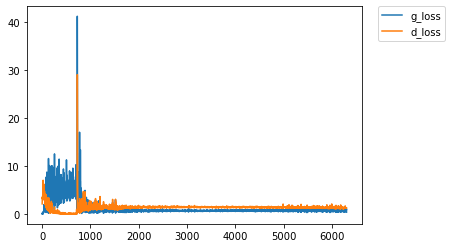

In [ ]:
# Loss Plotting
plt.plot(g_losses, label='g_loss')
plt.plot(d_losses, label='d_loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

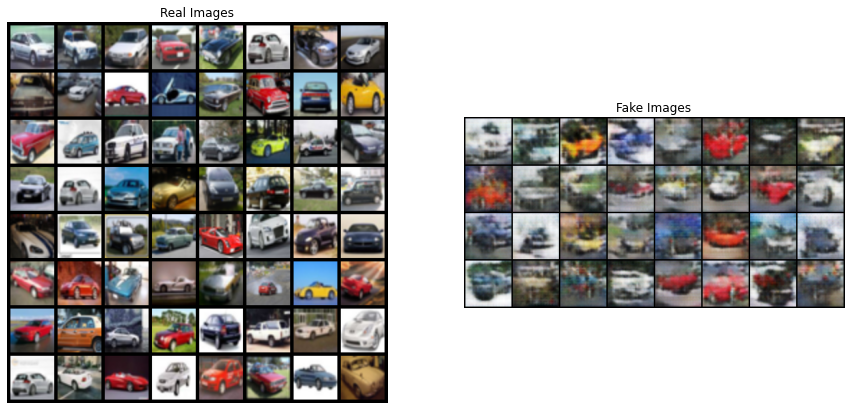

In [ ]:
# batch of real images from the dataloader
real_batch = next(iter(train_loader))
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()